In [2]:
from toqito.rand import random_psd_operator
import picos as pc
import numpy as np
from common import PauliSum
from collections import Counter
from scipy.stats import ortho_group, wishart
from scipy.stats import arcsine, uniform, norm
from scipy.linalg import eigvalsh
from scipy.sparse import csr_array, eye_array, csr_matrix, eye
from scipy.sparse.linalg import matrix_power as sparse_power
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sympy.matrices import Matrix
import itertools as it

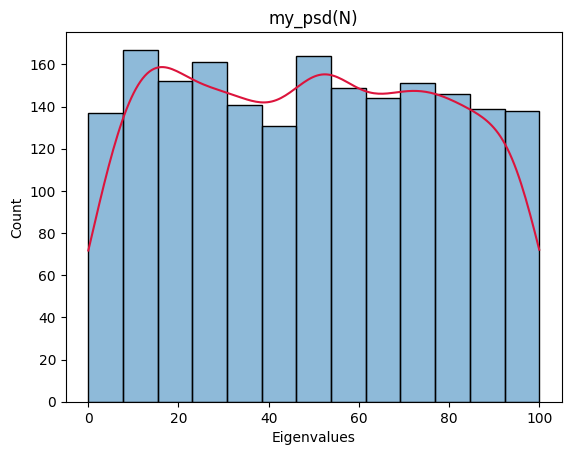

In [1068]:
def my_psd(N):
    D = np.diag(uniform.rvs(scale=100,size=N))
    Q = ortho_group.rvs(N)
    return Q @ D @ Q.T

def comm_psd(H, k):
    # https://mathoverflow.net/questions/65796/when-matrices-commute
    # Create a random polynomial of degree k in H
    c = norm.rvs(size=k)
    G = np.zeros((H.shape[0], H.shape[0]))
    P = np.eye(H.shape[0])
    for i in range(k):
        G += c[i] * P
        P @= H
        P /= np.max(np.abs(P))
    return G

import matplotlib.pyplot as plt
import seaborn as sns

eigs_mpsd = []
for _ in range(30):
    eigs_mpsd.extend(eigvalsh(my_psd(2 ** 6)).tolist())
plt.title('my_psd(N)')
ax = sns.histplot(data=eigs_mpsd, kde=True)
ax.lines[0].set_color('crimson')
plt.xlabel('Eigenvalues')
plt.show()

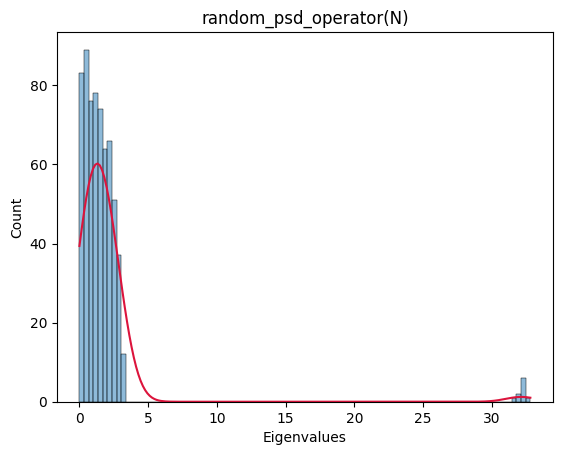

In [430]:
from toqito.rand import random_psd_operator
import matplotlib.pyplot as plt
import seaborn as sns

eigs_rpsd = []
for _ in range(10):
    eigs_rpsd.extend(eigvalsh(random_psd_operator(2 ** 6, is_real=True)).tolist())
plt.title('random_psd_operator(N)')
ax = sns.histplot(data=eigs_rpsd, kde=True)
ax.lines[0].set_color('crimson')
plt.xlabel('Eigenvalues')
plt.show()

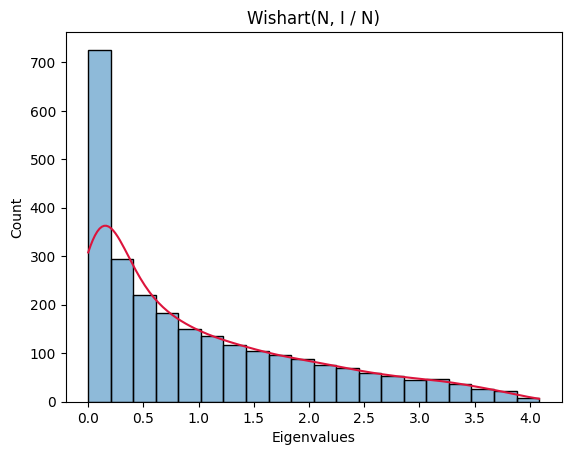

In [431]:
from scipy.stats import wishart
import matplotlib.pyplot as plt
import seaborn as sns

eigs_wishart = []
for _ in range(10):
    eigs_wishart.extend(eigvalsh(wishart.rvs(2 ** 8, np.eye(2 ** 8) / 2 ** 8)).tolist())
plt.title('Wishart(N, I / N)')
ax = sns.histplot(data=eigs_wishart, kde=True)
ax.lines[0].set_color('crimson')
plt.xlabel('Eigenvalues')
plt.show()

In [201]:
Hp = PauliSum.from_matrix(construct_hamil(8, 1).to_matrix())

In [205]:
all_terms = set()
cp = Hp
for _ in range(32):
    all_terms.update(cp.terms.keys())
    cp = cp * Hp
print(len(all_terms))

32740


In [26]:
def construct_hamil(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil[t1] = -1
        hamil[t2] = -h
    if L == 2:
        hamil = Counter({'IZ': -h, 'ZI': -h, 'XX': -1})
    return PauliSum(hamil)

def comm_psd_solve(L, h, d):
    H = construct_hamil(L, h).to_matrix()
    basis = [np.eye(2 ** L)]
    for _ in range(1, d + 1):
        P = basis[-1] @ H
        P /= np.max(P)
        basis.append(P)
    trM = pc.Constant("trM", [np.float64(np.trace(M)) for M in basis])
    trMH = pc.Constant("trMH", [np.float64(np.trace(M @ H)) for M in basis])
    prob = pc.Problem()
    c = pc.RealVariable('c', d + 1)
    rho = pc.SymmetricVariable('rho', H.shape[0])
    prob.add_constraint(c.T * trM == 1)
    prob.add_constraint(rho == pc.sum([c[i] * basis[i] for i in range(d + 1)]))
    prob.add_constraint(rho >> 0)
    prob.set_objective("min", c.T * trMH)
    # print('Actually solving...')
    prob.solve(dualize=True)
    print(prob)
    # print(c.value)
    return prob.value

def comm_psd_solve_sparse(L, h, d):
    H = csr_matrix(construct_hamil(L, h).to_matrix(), dtype=np.float64)
    basis = [eye(2 ** L, 2 ** L, format='csr')]
    for k in range(1, d + 1):
        P = sparse_power(H, k)
        P /= np.max(P)
        basis.append(P)
    trM = pc.Constant("trM", [np.float64(M.trace()) for M in basis])
    trMH = pc.Constant("trMH", [np.float64((M @ H).trace()) for M in basis])
    prob = pc.Problem()
    c = pc.RealVariable('c', len(basis))
    # prob.add_constraint(c >= 0)
    prob.add_constraint(c.T * trM == 1)
    prob.add_constraint(pc.sum([c[i] * pc.Constant(basis[i]) for i in range(len(basis))]) >> 0)
    prob.set_objective("min", c.T * trMH)
    print('Actually solving...')
    prob.solve(dualize=True)
    # print(prob)
    # print(c.value)
    return prob.value

def rand_solve(L, h, k, d):
    H = construct_hamil(L, h).to_matrix()
    psd_basis = [None for _ in range(k)]
    for i in range(k):
        # psd_basis[i] = comm_psd(H, d)
        psd_basis[i] = random_psd_operator(2 ** L, is_real=True)
        # psd_basis[i] = my_psd(2 ** L)
        # psd_basis[i] = wishart.rvs(2 ** L, np.eye(2**L))
    trM = pc.Constant("trM", [np.trace(M) for M in psd_basis])
    trMH = pc.Constant("trMH", [np.trace(M @ H) for M in psd_basis])
    prob = pc.Problem()
    c = pc.RealVariable('c', k)
    prob.add_constraint(c.T * trM == 1)
    prob.add_constraint(pc.sum([c[i] * pc.Constant(psd_basis[i]) for i in range(k)]) >> 0)
    prob.set_objective("min", c.T * trMH)
    # prob.add_constraint(c >= 0)
    # rho = pc.SymmetricVariable("rho", 2 ** L)
    # prob.add_constraint(rho >> 0)
    # prob.add_constraint(rho == pc.sum([c[i] * pc.Constant(psd_basis[i]) for i in range(k)]))
    # prob.add_constraint(pc.trace(rho) == 1)
    # prob.set_objective("min", rho | H)
    prob.solve()
    # print(prob)
    # print(c.value)
    return prob.value

def dm_energy(L, h):
    prob = pc.Problem()
    hamil = construct_hamil(L, h)
    H = hamil.to_matrix()
    # H = csr_array(hamil.to_matrix())
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho | H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    return prob.solve()

In [36]:
dm_energy(10, 1).value

-12.784906442999347

In [ ]:
comm_psd_solve(7, 1, 6)

Semidefinite Program
  minimize cᵀ·trMH
  over
    7×1 real variable c
    128×128 symmetric variable rho
  subject to
    cᵀ·trM = 1
    rho = ∑(c[i]·[128×128] : i ∈ [0…6])
    rho ≽ 0


-7.532619855235323

In [38]:
comm_psd_solve_sparse(10, 1, 14)

Actually solving...


-12.394299988780865

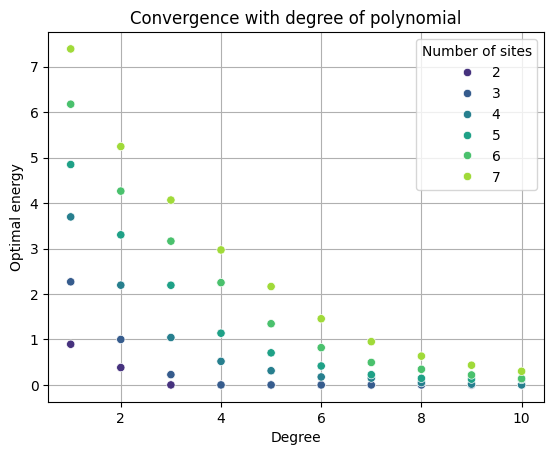

In [ ]:
L, h = 3, 1
data = []
# opt_data = []
seld = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sell = [2, 3, 4, 5, 6, 7]
for L in sell:
    opt = dm_energy(L, h).value
    # opt_data.append(opt)
    for d in seld:
        data.append([np.abs(opt - comm_psd_solve_sparse(L, h, d)), L, d])  
df = pd.DataFrame(data, columns=["Optimal energy", "Number of sites", "Degree"])

Text(0, 0.5, 'Absolute error')

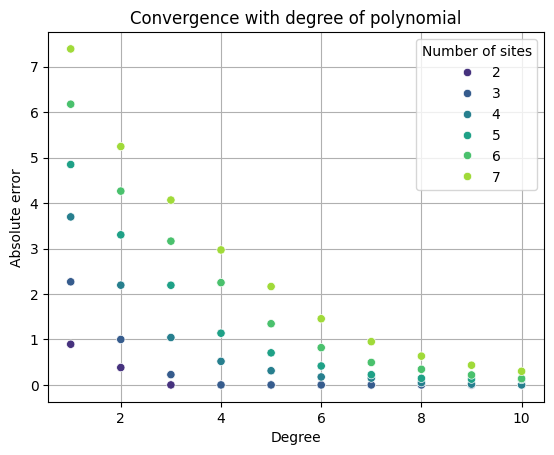

In [243]:
cmap = sns.color_palette("viridis")[:len(sell)]
sns.scatterplot(df, x="Degree", y="Optimal energy", hue="Number of sites", palette=cmap, zorder=10)
plt.title('Convergence with degree of polynomial')
plt.grid()
plt.ylabel("Absolute error")

In [1089]:
L, h = 5, 1
data = []
sel = [(5, 4), (5, 5), (5, 6)]
for _ in range(100):
    for k, d in sel:
        data.append([rand_solve(L, h, k, d), k, d])
df = pd.DataFrame(data, columns=["Optimal energy", "Matrix count", "Degree"])
print(df)

     Optimal energy  Matrix count  Degree
0         -4.279819             5       4
1         -5.334591             5       5
2         -5.677570             5       6
3         -4.279819             5       4
4         -5.334592             5       5
..              ...           ...     ...
295       -5.334591             5       5
296       -5.488154             5       6
297       -4.279819             5       4
298       -5.334591             5       5
299       -5.724204             5       6

[300 rows x 3 columns]


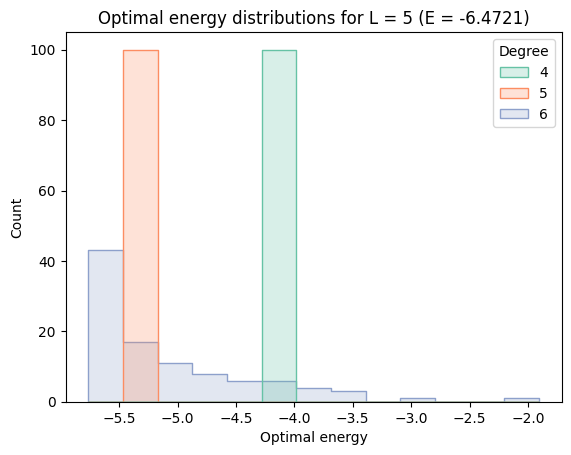

In [1090]:
actual = dm_energy(L, h).value
sns.histplot(df[df["Matrix count"].isin([5])], x="Optimal energy", hue="Degree", element="step", palette=sns.color_palette("Set2")[:len(sel)])
plt.title(f"Optimal energy distributions for L = {L} (E = {actual:.4f})")
plt.show()

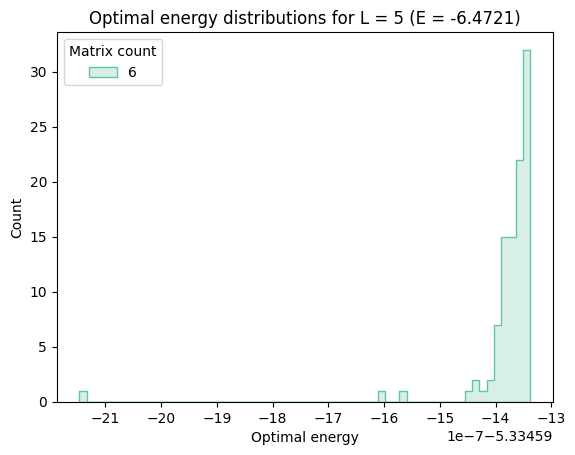

In [1073]:
actual = dm_energy(L, h).value
sns.histplot(df[df["Matrix count"].isin(sel)], x="Optimal energy", hue="Matrix count", element="step", palette=sns.color_palette("Set2")[:len(sel)])
plt.title(f"Optimal energy distributions for L = {L} (E = {actual:.4f})")
plt.show()

In [690]:
L, h = 2, 1
print(rand_solve(L, h, 4))
print(dm_energy(L, h).value)

Semidefinite Program
  minimize ⟨rho, [4×4]⟩
  over
    4×1 real variable c
    4×4 symmetric variable rho
  subject to
    rho ≽ 0
    rho = ∑(c[i]·[4×4] : i ∈ [0…3])
    tr(rho) = 1
[ 5.36e-01]
[ 1.51e-01]
[-3.76e-01]
[-6.06e-02]

-1.3637987359114687
-2.2360679774442236


In [ ]:
eigs_rpsd = []
eigs_wishart = []
for _ in range(10):
    eigs_rpsd.extend(eigvalsh(random_psd_operator(2 ** 5, is_real=True)).tolist())
    eigs_wishart.extend(eigvalsh(wishart.rvs(2 ** 8, np.eye(2 ** 8) / 2 ** 8)).tolist())
fig, axs = plt.subplots(2)
fig.suptitle('Eigenvalue distributions for random PSD matrix generation methods')
axs[0].set_title('random_psd_operator(N)')
axs[1].set_title('Wishart(N, I / N)')
sns.histplot(data=eigs_rpsd, kde=True, ax=axs[0])
sns.histplot(data=eigs_wishart, kde=True, ax=axs[1])
fig.tight_layout()
plt.show()

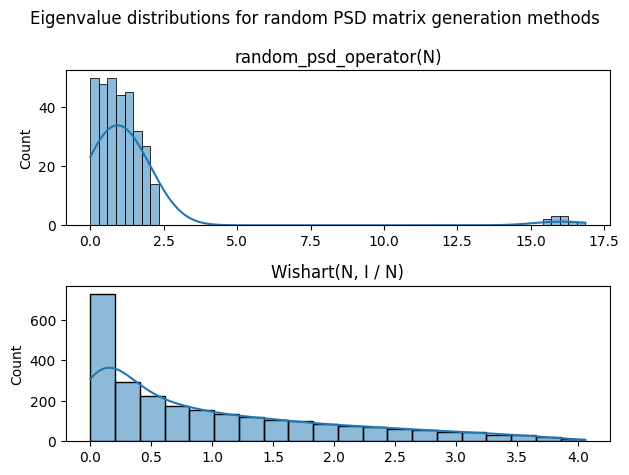

In [415]:
eigs_rpsd = []
eigs_wishart = []
for _ in range(10):
    eigs_rpsd.extend(eigvalsh(random_psd_operator(2 ** 5, is_real=True)).tolist())
    eigs_wishart.extend(eigvalsh(wishart.rvs(2 ** 8, np.eye(2 ** 8) / 2 ** 8)).tolist())
fig, axs = plt.subplots(2)
fig.suptitle('Eigenvalue distributions for random PSD matrix generation methods')
axs[0].set_title('random_psd_operator(N)')
axs[1].set_title('Wishart(N, I / N)')
sns.histplot(data=eigs_rpsd, kde=True, ax=axs[0])
sns.histplot(data=eigs_wishart, kde=True, ax=axs[1])
fig.tight_layout()
plt.show()

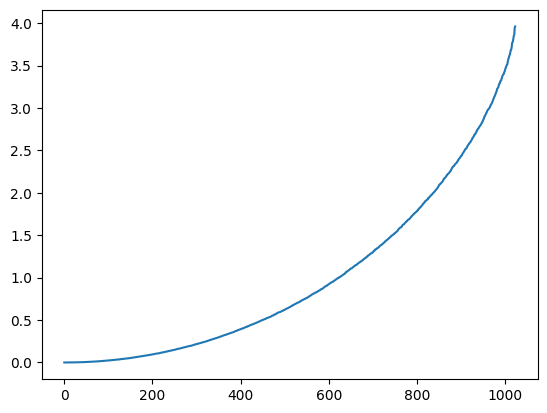

In [393]:
# eigs = eigvalsh(random_psd_operator(2 ** 5, is_real=True))
eigs = eigvalsh(wishart.rvs(2 ** 10, np.eye(2 ** 10) / 2 ** 10))
plt.plot(np.arange(eigs.shape[0]),eigs)

In [94]:
def rand_psd_basis(L, k):
    psd_basis = [None for _ in range(k)]
    for i in range(k):
        psd_basis[i] = random_psd_operator(2 ** L, is_real=True)
    return psd_basis